# WORK IN PROGRESS

# Introduction

This notebook is partly based on the work of Will Koehrsen's [Book Recommendation System.ipynb](http://github.com/WillKoehrsen/wikipedia-data-science/blob/master/notebooks/Book%20Recommendation%20System.ipynb) and Georgios Drakos' [Sentiment Analysis on IMDB movie dataset - Achieve state of the art result using a simple Neural Network](https://gdcoder.com/sentiment-analysis-on-imdb-movie-dataset-achieve-state-of-the-art-result-using-a-simple-neural-network/). 

It involves an NLP excercise of the [IMDB sentiment data set](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) where I have used a simple neural network with an embedding layer in order to predict whether a film review has a positive or negative sentiment. 

The notebook starts out with some minor EDA and data cleaning & preprocessing. The latter part contains the modelling, model evaluation and some analysis of the embeddings.

Please, if you have any input or feedback regarding this notebook, comment below.

# Import libraries & data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
import nltk
import re
from tensorflow import keras
from sklearn.manifold import TSNE
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
pd.set_option("display.max_rows", 50, "display.max_columns", 50)

In [ ]:
data = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

## Minor analysis of response variable

We encode the sentiment variable (response) as positive -> 1 and negative -> 0

In [ ]:
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data.head()

What is the distribution of positive and negative reviews?

In [ ]:
plt.figure(figsize=(6,3))
data.sentiment.value_counts().plot(kind='bar', rot=360)
plt.show()

We see that the data is *balanced*. This means that accuracy can be used as an evaluation metric. If we would have an imbalanced data set, then another metric would have been more suitable such as AUC or F1-score.

# Data cleaning and preprocessing

## Data cleaning

Let's have a look at the reviews. We print the first review in the data set.

In [ ]:
print(data.review[0])

We can see in the review above that there is some HTML code in the review. Now, what we want to do is to get rid of the HTML code and do some other cleaning with reviews. The other cleaning we want to do is:

* Transform all the words into low case characters
* Stem and lematize the words
* Remove stopwords

A good page you can read about stemming and lematization is found [here](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python).

In [ ]:
stopWords = nltk.corpus.stopwords.words('english')
snoStemmer = nltk.stem.SnowballStemmer('english')
wnlemmatizer = nltk.stem.WordNetLemmatizer()

def clean_html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def clean_punc(word):
    cleaned = re.sub(r'[?|!|\'|#]', r'', word)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

def filtered_sents(data_frame):
    # Creating a list of filtered sentences:
    final_string = []
    s = ''
    for sentence in data_frame:
        filtered_sentence = []
        sentence = clean_html(sentence)
        for word in sentence.split():
            for cleaned_word in clean_punc(word).split():
                if (cleaned_word.isalpha() and (len(cleaned_word) > 2) and cleaned_word not in stopWords):
                    lemmatized_word = wnlemmatizer.lemmatize(cleaned_word.lower())
                    stemmed_word = snoStemmer.stem(lemmatized_word)
                    filtered_sentence.append(stemmed_word)
                else:
                    continue
        strl = ' '.join(filtered_sentence)
        final_string.append(strl)
    return final_string

data.cleaned_review = filtered_sents(data.review)

Let's have a look at the cleaned review.

In [ ]:
print(data.cleaned_review[0])

The review may not make so much sense to us when we read it, but it is now cleaned from stopwords, it is lower cased, stemmed and lematized, as we want it to be.

## Tokenization

Now we need to tokenize the reviews. This means that instead of having words in the reviews, we will have numbers that represent the words. Every word is represented by a unique number which in turn will have a unique coordinate in our embedding layer, see the figure ([ref](https://medium.com/@JMangia/coreml-with-glove-word-embedding-and-recursive-neural-network-part-2-ab238ca90970)) below.

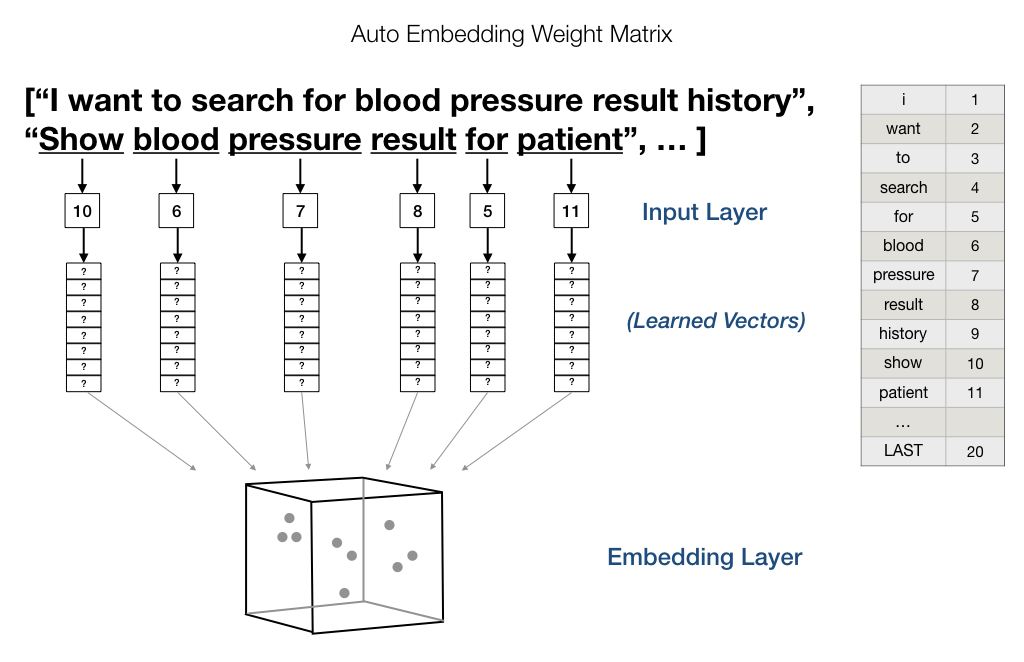

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.cleaned_review)
list_tokenized_data = tokenizer.texts_to_sequences(data.cleaned_review)
word_index = tokenizer.word_index
index_word = dict([(value, key) for (key, value) in word_index.items()])

In the output below we see that the words have been transformed as the following:

* movi (movie) -> 1
* film -> 2
* the -> 3
* one -> 4
* like -> 5

We also see in the cell beneath that we have 66020 unique words in total.


In [ ]:
print(pd.Series(word_index).head())
print('\n')
print(pd.Series(word_index).tail())

## Preprocessing

How many words (numbers) do the reviews contain? Let's have a look at the length of the reviews.

In [ ]:
length_list = []
for i in list_tokenized_data:
    length_list.append(len(i))

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False)
pd.Series(length_list).hist(bins=100, ax = axes[0])
pd.Series(length_list).hist(bins=100, ax = axes[1])
plt.xlim(0,400)
plt.show()

We see that most reviews contain around 60-80 words and that there are few reviews longer than 300 words. Now we need to have the reviews in the same form. What we want is a matrix X that represent the reviews as rows and the features as columns. This means that we neew to have a fixed length of every review so that every review has the same amount of features. I chose to have a length of 256 because I think it is a nice number :).

When we have created the matrix X with all of the reviews, we then divide the rows into train, validation and test sets.

In [ ]:
MAX_LEN = 256
X = keras.preprocessing.sequence.pad_sequences(list_tokenized_data,
                                                        padding='post',
                                                        maxlen=MAX_LEN)
y = data.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)
print(f'SHAPE: \n X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val:{y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

# Modelling

I chose the architecture to be a simple feed forward neural network with an embedding layer. The model has regularization in the dense layer and a dropout layer (with quite high dropout number) in order to prevent overfit.



In [ ]:
vocab_size = max(np.max(X_train), np.max(X_test)) + 1
emb_size = 16
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, emb_size, input_length = MAX_LEN, name = 'word_embedding'))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(emb_size, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(keras.layers.Dropout(0.5, seed=0))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
LEARNING_RATE = 1e-3
OPTIMIZER = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=['acc'])

CALLBACKS = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
history = model.fit(X_train,
            y_train,
            epochs=100,
            batch_size=512,
            validation_data=(X_val, y_val),
            verbose=1,
            callbacks=CALLBACKS)

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Model evaluation

How well are we fitting the data? Do we underfit, overfit or are we just about right? Let's have a look at the training and validation curves.

In [ ]:
history_dict = history.history
metric_list = list(history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']
# "bo" is for "blue dot"
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

if 'acc' in metric_list:
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    
elif 'auc' in metric_list:
    auc = history_dict['auc']
    val_auc = history_dict['val_auc']
    plt.plot(epochs, auc, 'bo', label='Training auc')
    plt.plot(epochs, val_auc, 'b', label='Validation auc')
    plt.ylabel('AUC')
    plt.title('Training and validation auc')
    
elif 'precision' and 'recall' in list(metric_list):
    precision = history_dict['precision']
    val_precision = history_dict['val_precision']
    recall = history_dict['recall']
    val_recall = history_dict['val_recall']
    plt.plot(epochs, precision, 'bo', label='Training precision')
    plt.plot(epochs, val_precision, 'b', label='Validation precision')
    plt.plot(epochs, recall, 'ro', label='Training recall')
    plt.plot(epochs, val_recall, 'r', label='Validation recall')
    plt.ylabel('Precision and Recall')
    plt.title('Training and validation precision and recall')

plt.xlabel('Epochs')
plt.legend()
plt.show()

We see that the training and the validation curves behave OK (but we might be able to tune the regularization or dropout to reduce the minor overfit). You can read about how to interpret learning and validation curves [here](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

# Embeddings and t-SNE

In order to get an understanding about the embeddings of the words we can compare the cosine similarity of the words. 

Further, we can use t-SNE and plot the results in order to see the representation of the words in the embedding.

## Preprocessing of the embedding layer

In [ ]:
# Extract embeddings
word_layer = model.get_layer('word_embedding')
word_weights = word_layer.get_weights()[0]
word_weights.shape

In [ ]:
word_weights = word_weights / np.linalg.norm(word_weights, axis = 1).reshape((-1, 1))
word_weights[0][:10]
np.sum(np.square(word_weights[0]))

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'word', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'word':
        index = word_index
        rindex = index_word
    elif index_name == 'page':
        index = link_index
        rindex = index_link
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between word and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        #print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    #for c in reversed(closest):
        #print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')
        
    return closest

## Visualizations of the embedding

Let's have a look at the similarities and dissimilarities of the word 'amaz' ('amazing').

In [ ]:
find_similar('amaz', word_weights, least = True, n = 5, plot = True)

Looks pretty reasonable.

Now, let's have a look at a more neutral word as 'livingroom'.

In [ ]:
find_similar('livingroom', word_weights, least = True, n = 5, plot = True)

Seems like the words that are similar to 'livingroom' are quite neutral as well.

We continue with the t-SNE analysis.

In [ ]:
def reduce_dim(weights, components = 2, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine', random_state=0).fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [ ]:
word_r = reduce_dim(word_weights, components = 2, method = 'tsne')
word_r.shape

Let's have a look at the embeddings with help the of t-SNE. 

In the plot below we can see three clusters. One for positive words, one for negative words and one that seems to be for the neutral words. In the plot it is shown the five most similar words to the positive word "great", five most similar words to the negative word "bad" and the five most similar words to the neutral word "livingroom".

Do not know why there are multiple occurances of the same word in the plot at the moment, haven't figured that out yet. 

In [ ]:
clustered_pos = find_similar('great', word_weights, n = 10)
clustered_neg = find_similar('bad', word_weights, n = 10)
clustered_neutral = find_similar('livingroom', word_weights, n = 10)
np.random.seed(seed=0)
clustered_pos = np.random.choice(clustered_pos, 5)
np.random.seed(seed=0)
clustered_neg = np.random.choice(clustered_neg, 5)
np.random.seed(seed=0)
clustered_neutral = np.random.choice(clustered_neutral, 5)
clustered_words = np.concatenate((clustered_pos, clustered_neg))
clustered_words = np.concatenate((clustered_words, clustered_neutral))

InteractiveShell.ast_node_interactivity = 'last' 
plt.figure(figsize = (14, 12))

#Plot all words
fig = plt.scatter(word_r[:, 0], word_r[:, 1], marker = '.', color = 'lightblue')

plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Word Embeddings');
np.random.seed(seed=0)
for index in clustered_words: 
    x, y = word_r[index, 0], word_r[index, 1];
    s = ''.join([' $\it{'+ i + '}$' for i in index_word[index].split()])
    plt.scatter(x, y, s = 250, color = 'r', marker = '*', edgecolor = 'k')
    plt.text(x + np.random.randint(-5,5), y + np.random.randint(-5,5), s, fontsize = 14);
plt.show()

This notebook is under construction so mistakes/errors are probably present. Again, let me know if you have any input! 